In [1]:
1+1

2

In [2]:
import pynbody as pnb
import pynbody.plot.sph as sph

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
import scipy.stats as ss
from pytreegrav import Potential, PotentialTarget

In [3]:
def load_snapshot0(sim_name, z = -1): #load z=0 snapshot
    if sim_name == 'Romulus25':
        simdir = '/project/rrg-babul-ad/rennehan/romulus_data/cosmo25/'
        param_file = simdir+'cosmo25p.768sg1bwK1BHe75_v4.param'

        ## load snapshot numbers
        filelist = os.listdir(simdir)
        result = [i[-6:] for i in filelist if i.startswith('cosmo25p.') and len(i)==31]
        result.sort()
        result = result[4:]
        snap = result[z] # snapshot id of z=0 snapshot (i.e. the most recent snapshot)
        data_file = simdir+'cosmo25p.768sg1bwK1BHe75.'+snap
        
    elif sim_name == 'RomulusC':
        simdir = '/project/rrg-babul-ad/rennehan/romulus_data/h1.cosmo50/'
        param_file = '/project/rrg-babul-ad/rennehan/romulus_data/h1.cosmo50/h1.cosmo50PLK.1536gst1bwK1BH.param'

        filelist = os.listdir(simdir)
        result = [i[-6:] for i in filelist if i.startswith('h1.cosmo50') and len(i)==35]
        result.sort()
        snap = result[-1]
        data_file = simdir+'h1.cosmo50PLK.1536gst1bwK1BH.'+snap

    elif sim_name == 'RomulusG1':
        simdir = '/project/rrg-babul-ad/rennehan/romulus_data/h102054gs/'
        param_file = '/project/rrg-babul-ad/rennehan/romulus_data/h102054gs/h102054gs.param'

        filelist = os.listdir(simdir)
        result = [i[10:-10] for i in filelist if i.startswith('h102054gs.') and len(i)==26]
        result.sort()
        snap = result[-1]
        data_file = simdir+'h102054gs.'+snap
        
    elif sim_name == 'RomulusG2':
        simdir = '/project/rrg-babul-ad/rennehan/romulus_data/h82651gs/'
        param_file = '/project/rrg-babul-ad/rennehan/romulus_data/h82651gs/h82651gs.param'
        result = [i[9:-10] for i in filelist if i.endswith('amiga.grp') and len(i)==25]
        result.sort()
        snap = result[-1]
        data_file = simdir+'h82651gs.'+snap

    s = pnb.load(data_file, paramfile = param_file)
    s.physical_units()
    return(s)

In [4]:
s = load_snapshot0('Romulus25')

In [5]:
h = s.halos(ahf_mpi = True) #load halo catalogue
len(h) # There are a LOT of halos at z=0. You'll need to decide what kind of sample you want. (e.g., mass, host halo, etc)

103222

In [6]:
#haloid = 65502
#haloid = 99966
## Haloids of 19 most massive halos in ROMULUS
halolist = np.array([39963.0, 49047.0, 67526.0, 89615.0, 52024.0, 79654.0, 99966.0, 49510.0, 27666.0, 42778.0, 14620.0, 97045.0, 61270.0, 77876.0, 65502.0, 18714.0, 91655.0, 82151.0, 38182.0], dtype = int)

## Haloids of Spheroidal halos in ROMULUS
#halolist = np.array([82151, 49510, 13455,     1, 30900, 87235, 98808])

In [16]:
#haloid = halolist[1]
haloid = 77876
h0 = h[haloid]
haloid

77876

In [17]:
## Determine the center of mass of the given particles, then recenter accordingly
pnb.analysis.halo.center(h0, mode='pot', move_all = True, vel = True)
com = pnb.analysis.halo.center_of_mass(h0)
vcom = pnb.analysis.halo.center_of_mass_velocity(h0)

In [18]:
#calculate and find the R500 and M500
import XIGrM.calculate_R as cR
import XIGrM.cosmology as cos
prop = s.properties
virovdens = cos.Delta_vir(s)
rdict = {'vir': virovdens,'200': 200, '500': 500, '2500': 2500}
center = com
#dic
MassRadii = cR.get_radius(h0, overdensities=list(rdict.values()), rho_crit=None, prop=prop, precision=1e-2, cen=center, rmax=None)

print(MassRadii)

({102.9: SimArray(2.5573552e+12, dtype=float32, 'Msol'), 200.0: SimArray(2.2467185e+12, dtype=float32, 'Msol'), 500.0: SimArray(1.859174e+12, dtype=float32, 'Msol'), 2500.0: SimArray(1.2172177e+12, dtype=float32, 'Msol')}, {102.9: SimArray(359.7432659, 'kpc'), 200.0: SimArray(276.32502206, 'kpc'), 500.0: SimArray(191.27835255, 'kpc'), 2500.0: SimArray(97.11171916, 'kpc')})


In [19]:
virovdens

102.9

In [20]:
pnb.analysis.angmom.faceon(h0, move_all = False)

In [ ]:
pnb.analysis.angmom.sideon(h0, move_all = False)

In [21]:
primary_halo = h0.star[h0.star['grp'] == haloid]

Freedman–Diaconis number of bins: 638


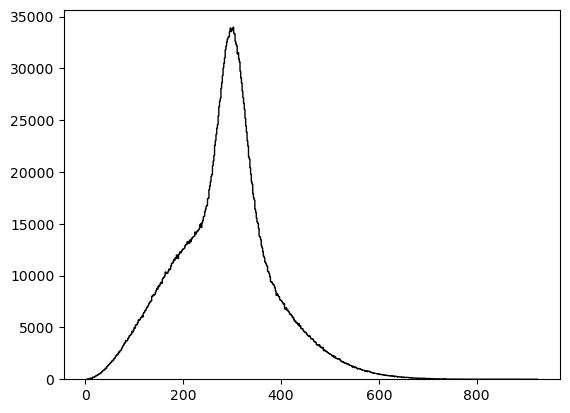

In [28]:
v2 = primary_halo.star['v2']
v = np.sqrt(v2)

q25, q75 = np.percentile(v, [25, 75])
bin_width = 2 * (q75 - q25) * len(v) ** (-1/3)
bins = round((v.max() - v.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

n_bins = int(bins)
hist, bin_edges = np.histogram(v, bins = n_bins)
v_med = []
for i in range(n_bins):
    v_med.append(np.mean(bin_edges[i: i+2]))

v_med = np.array(v_med)
hist = np.array(hist)

from scipy.optimize import fsolve, curve_fit
order = 0.5
from scipy.special import iv

def New_maxwell(vel, v0, sigma, k):
    vel = vel/sigma
    Lambda = v0**2/sigma**2
    mod_bessel = iv(order, np.sqrt(Lambda*vel**2))
    non_central_chi_sq =  (0.5 * np.exp( -(vel**2 + Lambda)/2 ) * (vel**2/Lambda)**(3/4 - 1/2) ) * mod_bessel * 2 * vel
    return k * non_central_chi_sq

def double_maxwell(vel, v0, sigma0, k0, v1, sigma1, k1):
    return New_maxwell(vel, v0, sigma0, k0) + New_maxwell(vel, v1, sigma1, k1)

def triple_maxwell(vel, v0, sigma0, k0, v1, sigma1, k1, v2, sigma2, k2):
    return New_maxwell(vel, v0, sigma0, k0) + New_maxwell(vel, v1, sigma1, k1) + New_maxwell(vel, v2, sigma2, k2)

def Maxwell(v, sigma, k):
    return k * v**2 * np.exp(-v**2/sigma**2) / sigma**(3/2)

def double_maxwell(v, sigma, k, v01, sigma1, k1):
    return Maxwell(v, sigma, k) + New_maxwell(v, v01, sigma1, k1)

def Triple_maxwell(v, sigma, k, v01, sigma1, k1, sigma2, k2):
    return Maxwell(v, sigma, k) + New_maxwell(v, v01, sigma1, k1) + Maxwell(v, sigma2, k2)

def triple_maxwell(v, sigma, k, sigma1, k1, sigma2, k2):
    return Maxwell(v, sigma, k) + Maxwell(v, sigma1, k1) + Maxwell(v, sigma2, k2)

x = plt.hist(v, bins = n_bins, histtype = 'step', color = 'black', label = 'Romulus data')

array([2.50832809e+02, 2.21195704e+03, 2.99229141e+02, 2.88981569e+01,
       5.22695685e+04, 2.50834135e+02, 1.00551870e+02])

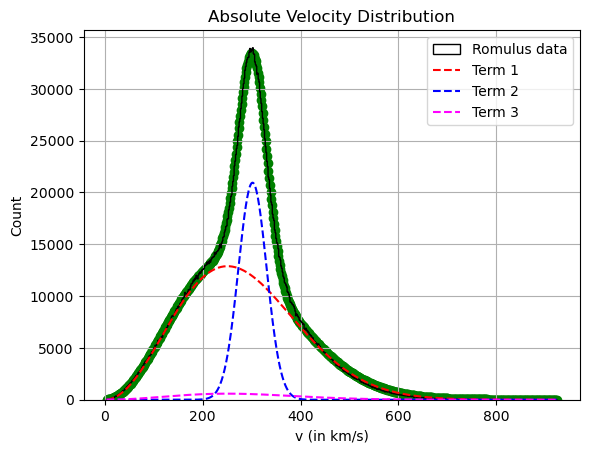

In [34]:
opt, cov = curve_fit(Triple_maxwell, v_med, hist, p0 = [350, 4000, 350, 80, 10**5, 200, 15000], bounds = ([100, 500, 200, 10, 10**2, 0, 100], [450, 18000, 450, 250, 10**6, 300, np.inf]))
f_v = []
term1 = []
term2 = []
term3 = []
for x in v_med:
    f_v.append(Triple_maxwell(x, *opt))
    term1.append(Maxwell(x, *opt[:2]))
    term2.append(New_maxwell(x, *opt[2:5]))
    term3.append(Maxwell(x, *opt[5:]))

plt.hist(v, bins = n_bins, histtype = 'step', color = 'black', label = 'Romulus data')
plt.scatter(v_med, f_v, color = 'green')
plt.plot(v_med, term1, color = 'red', linestyle = 'dashed', label = 'Term 1')
plt.plot(v_med, term2, color = 'blue', linestyle = 'dashed', label = 'Term 2')
plt.plot(v_med, term3, color = 'magenta', linestyle = 'dashed', label = 'Term 3')
plt.legend()
plt.grid()
plt.title('Absolute Velocity Distribution')
plt.xlabel('v (in km/s)')
plt.ylabel('Count')
#plt.savefig('COP velocities/Absolute Velocity Distribution 4.png')
opt

array([ 261.17601725, 3022.46207798,  250.        ,   75.        ,
       4999.99999995])

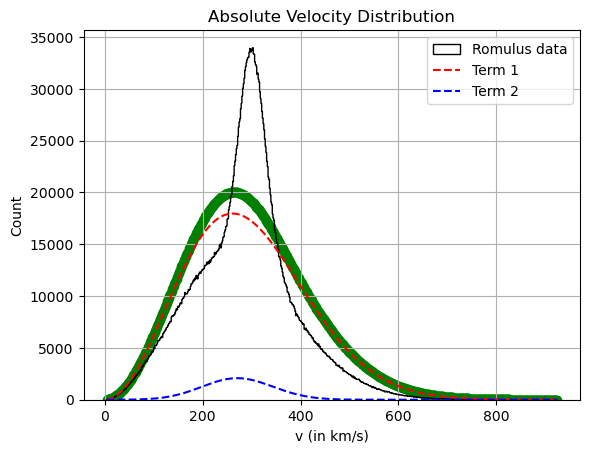

In [31]:
opt, cov = curve_fit(double_maxwell, v_med, hist, p0 = [173, 2108, 210, 100, 10**3], bounds = ([10, 2000, 10, 75, 70], [280, 4150, 250, 100, 5*10**3]))
f_v = []
term1 = []
term2 = []
for x in v_med:
    f_v.append(double_maxwell(x, *opt))
    term1.append(Maxwell(x, *opt[:2]))
    term2.append(New_maxwell(x, *opt[2:]))

plt.hist(v, bins = n_bins, histtype = 'step', color = 'black', label = 'Romulus data')
plt.scatter(v_med, f_v, color = 'green')
plt.plot(v_med, term1, color = 'red', linestyle = 'dashed', label = 'Term 1')
plt.plot(v_med, term2, color = 'blue', linestyle = 'dashed', label = 'Term 2')
plt.legend()
plt.grid()
plt.title('Absolute Velocity Distribution')
plt.xlabel('v (in km/s)')
plt.ylabel('Count')
#plt.savefig('COP velocities/Absolute Velocity Distribution 4.png')
opt

In [32]:
sigma1, sigma2 = opt[[0, 2]]

In [33]:
G = 6.674 * 10**-20
G

6.674e-20

In [35]:
pos = primary_halo['pos']
pos.units

Unit("kpc")

In [36]:
v2.units

Unit("km**2 s**-2")

In [37]:
Potential(np.array([[0, 0, 1], [0, 0, 0]]), np.array([1, 1]))

array([-1., -1.])

Text(0.5, 0, 'v (in km/s)')

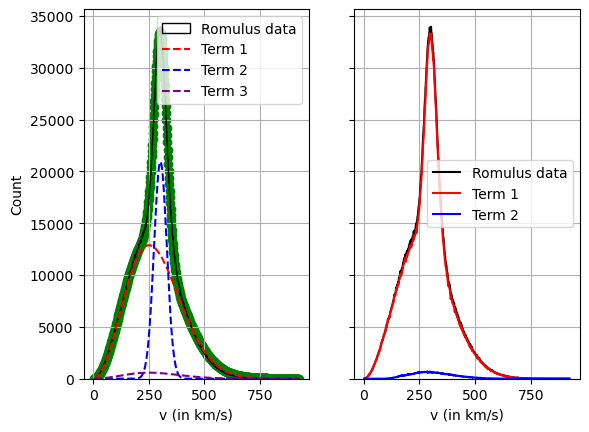

In [46]:
r_fid = 3*r_eff # kpc
cD = h0[pnb.filt.Sphere(r_fid)]
mass = cD['mass']
star_pos = primary_halo['pos']
source_pos = cD['pos']
potential = PotentialTarget(np.array(star_pos), np.array(source_pos), np.array(mass), method='tree', parallel=True)

G = 6.67*10**(-11) * (3.24*10**(-20)) * (2*10**30) * 10**(-6)
new_pot = G*potential

kin_energy = v2/2
kin_energy

total_energy = kin_energy + new_pot
unbound = primary_halo[np.where(total_energy > 0)[0]]
bound = primary_halo[np.where(total_energy <= 0)[0]]

v_b = np.sqrt(bound['v2'])
v_ub = np.sqrt(unbound['v2'])

h_bound, bin_edges = np.histogram(v_b, bins = bin_edges)
h_unbound, bin_edges = np.histogram(v_ub, bins = bin_edges)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(v, bins = n_bins, histtype = 'step', color = 'black', label = 'Romulus data')
ax1.scatter(v_med, f_v, color = 'green')
ax1.plot(v_med, term1, color = 'red', linestyle = 'dashed', label = 'Term 1')
ax1.plot(v_med, term2, color = 'blue', linestyle = 'dashed', label = 'Term 2')
ax1.plot(v_med, term3, color = 'purple', linestyle = 'dashed', label = 'Term 3')
ax1.legend()
ax1.grid()
ax1.set_xlabel('v (in km/s)')
ax1.set_ylabel('Count')

ax2.plot(v_med, hist, color = 'black', label = 'Romulus data')
ax2.plot(v_med, h_bound, color = 'red', label = 'Term 1')
ax2.plot(v_med, h_unbound, color = 'blue', label = 'Term 2')
ax2.legend()
ax2.grid()
ax2.set_xlabel('v (in km/s)')
#plt.savefig('COP velocities/Absolute Velocity Distribution 4.png')

In [52]:
primary_halo['eps'] = np.zeros(len(primary_halo)).astype(float32)
profile = pnb.analysis.profile.Profile(primary_halo, ndim = 2, rmin = r0, rmax = Rvir)
j_circ = profile['j_circ']
r_bins = profile['rbins']
plt.plot(r_bins, j_circ)

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'

In [ ]:
for vec in star_pos:
    

array([ 175.63381793, 4079.92705114])

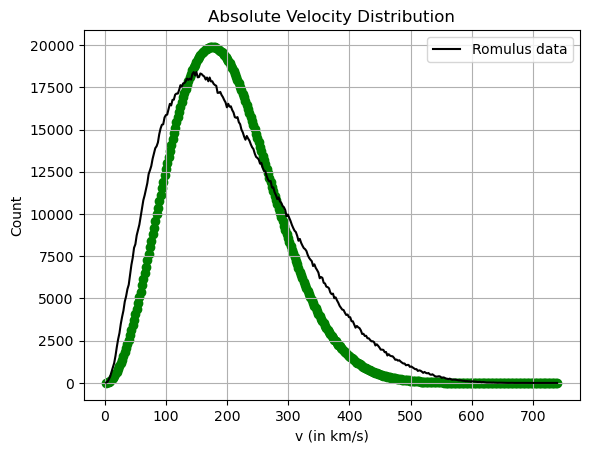

In [22]:
opt, cov = curve_fit(Maxwell, v_med, h_bound, p0 = [225, 1000], bounds = ([10, 500], [350, 8000]))
fit = []
for x in v_med:
    fit.append(Maxwell(x, *opt[:2]))

plt.plot(v_med, h_bound, color = 'black', label = 'Romulus data')
plt.scatter(v_med, fit, color = 'green')
plt.legend()
plt.grid()
plt.title('Absolute Velocity Distribution')
plt.xlabel('v (in km/s)')
plt.ylabel('Count')
#plt.savefig('COP velocities/Absolute Velocity Distribution 4.png')
opt

array([201.98839996, 561.93091719, 500.        , 100.0000002 ,
        74.11567789])

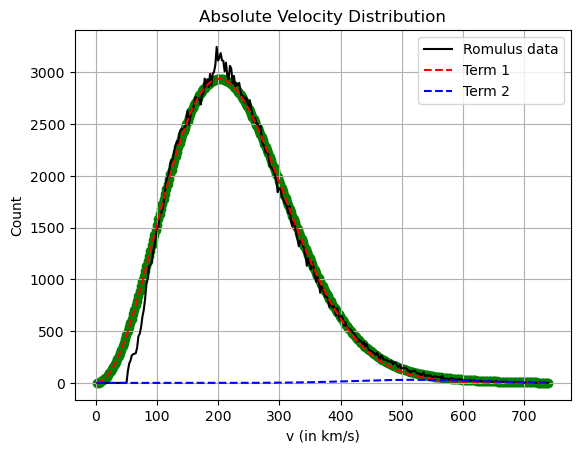

In [23]:
opt, cov = curve_fit(double_maxwell, v_med, h_unbound, p0 = [225, 4000, 300, 400, 10**3], bounds = ([100, 200, 300, 100, 70], [500, 8000, 500, 500, 10**5]))
f_v = []
term1 = []
term2 = []
for x in v_med:
    f_v.append(double_maxwell(x, *opt))
    term1.append(Maxwell(x, *opt[:2]))
    term2.append(New_maxwell(x, *opt[2:]))

plt.plot(v_med, h_unbound, color = 'black', label = 'Romulus data')
plt.scatter(v_med, f_v, color = 'green')
plt.plot(v_med, term1, color = 'red', linestyle = 'dashed', label = 'Term 1')
plt.plot(v_med, term2, color = 'blue', linestyle = 'dashed', label = 'Term 2')
plt.legend()
plt.grid()
plt.title('Absolute Velocity Distribution')
plt.xlabel('v (in km/s)')
plt.ylabel('Count')
#plt.savefig('COP velocities/Absolute Velocity Distribution 4.png')
opt

In [38]:
r0 = 0.5 # in kpc
Rvir = MassRadii[1][virovdens]

In [39]:
# Finding the effective radius, can take a while to run
r_arr = 10**np.linspace(np.log10(r0), np.log10(Rvir), 100)

In [40]:
mass = []
for i in range(100):
    current_region = primary_halo[pnb.filt.Sphere(r_arr[i])]
    mass.append(current_region.star['mass'].sum())

np.savetxt(f'mass_bins_{haloid}.txt', mass, delimiter = ' ')

In [41]:
mass = np.loadtxt(f'mass_bins_{haloid}.txt', delimiter = ' ')

half_mass = mass[-1]/2

m_arr = abs(mass - half_mass)
r_eff = r_arr[np.where(m_arr == min(m_arr))[0]]
r_eff

SimArray([4.78817163])

In [54]:
# Building the profile
N = 75 # number of bins
R0 = 0.5 # in kpc

log_bins = np.linspace(np.log10(R0), np.log10(Rvir), N)
bins = 10.0**log_bins
n_stars = []

# Uses Cylindrical Annulus instead of shells
r_plot = []
rho_plot = []
rho_bound = []
rho_unbound = []
max_diff = 0.15 # Maximum fractional difference between stars to the left and right of r_med

for i in range(N - 1):
    current_region = primary_halo[pnb.filt.SolarNeighborhood(r1 = bins[i], r2 = bins[i + 1], height = 2*Rvir)]
    bound_region = bound[pnb.filt.SolarNeighborhood(r1 = bins[i], r2 = bins[i + 1], height = 2*Rvir)]
    unbound_region = unbound[pnb.filt.SolarNeighborhood(r1 = bins[i], r2 = bins[i + 1], height = 2*Rvir)]
    n_stars = len(current_region)
    r_med = (bins[i] + bins[i + 1]) / 2
    n_left = len(primary_halo[pnb.filt.SolarNeighborhood(r1 = bins[i], r2 = r_med, height = 2*Rvir)])
    n_right = len(primary_halo[pnb.filt.SolarNeighborhood(r1 = r_med, r2 = bins[i + 1], height = 2*Rvir)])
    diff = abs(n_right - n_left)
    loop_count = 0
    while diff/n_stars >= max_diff:
        if loop_count == 4:
            break
        elif n_left > n_right:
            r_med = r_med * (1 - 0.1*diff/n_stars)
            print(f'{loop_count}, left, {diff/n_stars}')
        else:
            r_med = r_med * (1 + 0.05*diff/n_stars)
            print(f'{loop_count}, right, {diff/n_stars}')
        
        n_left = len(primary_halo[pnb.filt.SolarNeighborhood(r1 = bins[i], r2 = r_med, height = 2*Rvir)])
        n_right = len(primary_halo[pnb.filt.SolarNeighborhood(r1 = r_med, r2 = bins[i + 1], height = 2*Rvir)])
        diff = abs(n_right - n_left)
        loop_count = loop_count + 1
 
    r_plot.append(r_med)  
    mass = current_region['mass'].sum()
    rho = mass / (np.pi * (bins[i + 1]**2 - bins[i]**2))
    rho_plot.append(rho)
    
    mass = bound_region['mass'].sum()
    rho = mass / (np.pi * (bins[i + 1]**2 - bins[i]**2))
    rho_bound.append(rho)
    
    mass = unbound_region['mass'].sum()
    rho = mass / (np.pi * (bins[i + 1]**2 - bins[i]**2))
    rho_unbound.append(rho)
    print(f'Completed bin number {i + 1}')

Completed bin number 1
Completed bin number 2
Completed bin number 3
Completed bin number 4
Completed bin number 5
Completed bin number 6
Completed bin number 7
Completed bin number 8
Completed bin number 9
Completed bin number 10
Completed bin number 11
Completed bin number 12
Completed bin number 13
Completed bin number 14
Completed bin number 15
Completed bin number 16
Completed bin number 17
Completed bin number 18
Completed bin number 19
Completed bin number 20
Completed bin number 21
Completed bin number 22
Completed bin number 23
Completed bin number 24
Completed bin number 25
Completed bin number 26
Completed bin number 27
Completed bin number 28
Completed bin number 29
Completed bin number 30
Completed bin number 31
Completed bin number 32
Completed bin number 33
Completed bin number 34
Completed bin number 35
Completed bin number 36
Completed bin number 37
Completed bin number 38
Completed bin number 39
Completed bin number 40
Completed bin number 41
Completed bin number 42
C

In [55]:
# Run this if previous block was executed
r_num = np.array(r_plot)
rho_num = np.array(rho_plot)
np.savetxt(f'r_halo_cylinder_{haloid}.txt', r_num, delimiter = ' ')
np.savetxt(f'rho_halo_cylinder_{haloid}.txt', rho_num, delimiter = ' ')
np.savetxt(f'rho_halo_bound_{haloid}.txt', rho_bound, delimiter = ' ')
np.savetxt(f'rho_halo_unbound_{haloid}.txt', rho_unbound, delimiter = ' ')

In [59]:
r_plot = np.loadtxt(f'r_halo_cylinder_{haloid}.txt', delimiter = ' ')
rho_plot = np.loadtxt(f'rho_halo_cylinder_{haloid}.txt', delimiter = ' ')
rho_bound = np.loadtxt(f'rho_halo_bound_{haloid}.txt', delimiter = ' ')
rho_unbound = np.loadtxt(f'rho_halo_unbound_{haloid}.txt', delimiter = ' ')

In [60]:
idx = [-19, -18, -14, -13, -5, -4, -3]
idx2 = [-16, -11, -10, -6]

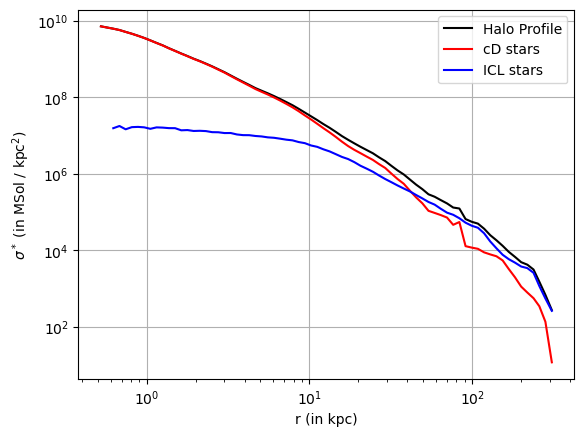

In [61]:
plt.plot(r_plot, rho_plot, color = 'black', label = 'Halo Profile')
plt.plot(r_plot, rho_bound, color = 'red', label = 'cD stars')
plt.plot(r_plot[2:], rho_unbound[2:], color = 'blue', label = 'ICL stars')
#plt.scatter(r_plot[idx], rho_bound[idx], color = 'red', marker = 'x')
#plt.scatter(r_plot[idx2], rho_bound[idx2], color = 'blue', marker = 'x')
plt.grid()
ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('r (in kpc)')
ax.set_ylabel(r'$\sigma^*$ (in MSol $/$ kpc$^2$)')
plt.legend()

In [23]:
from pynbody.filt import SolarNeighborhood

In [24]:
# Building the profile
N = 75 # number of bins
R0 = 0.5 # in kpc

log_bins = np.linspace(np.log10(R0), np.log10(Rvir), N)
bins = 10.0**log_bins

NameError: name 'Rvir' is not defined

In [37]:
peak_filt1 = SolarNeighborhood(bins[-20], bins[-18], 2*Rvir)
peak_stars1 = bound[peak_filt1]

peak_filt2 = SolarNeighborhood(bins[-15], bins[-13], 2*Rvir)
peak_stars2 = bound[peak_filt2]

peak_filt3 = SolarNeighborhood(bins[-6], bins[-3], 2*Rvir)
peak_stars3 = bound[peak_filt3]

In [38]:
trough_filt1 = SolarNeighborhood(bins[-17], bins[-16], 2*Rvir)
trough_stars1 = bound[trough_filt1]

trough_filt2 = SolarNeighborhood(bins[-12], bins[-10], 2*Rvir) 
trough_stars2 = bound[trough_filt2]

trough_filt3 = SolarNeighborhood(bins[-7], bins[-6], 2*Rvir)
trough_stars3 = bound[trough_filt3]

In [39]:
missing_band = bound[SolarNeighborhood(bins[-10], bins[-7], 2*Rvir)]
missing_pos = missing_band['pos']
miss_x = missing_pos[:, 0]
miss_y = missing_pos[:, 1]

/home/guru2k2/anaconda3/envs/new_env3/lib/python3.7/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


In [40]:
peak_pos1 = peak_stars1['pos']
peak_x1 = peak_pos1[:, 0]
peak_y1 = peak_pos1[:, 1]

peak_pos2 = peak_stars2['pos']
peak_x2 = peak_pos2[:, 0]
peak_y2 = peak_pos2[:, 1]

peak_pos3 = peak_stars3['pos']
peak_x3 = peak_pos3[:, 0]
peak_y3 = peak_pos3[:, 1]

In [41]:
trough_pos1 = trough_stars1['pos']
trough_x1 = trough_pos1[:, 0]
trough_y1 = trough_pos1[:, 1]

trough_pos2 = trough_stars2['pos']
trough_x2 = trough_pos2[:, 0]
trough_y2 = trough_pos2[:, 1]

trough_pos3 = trough_stars3['pos']
trough_x3 = trough_pos3[:, 0]
trough_y3 = trough_pos3[:, 1]

In [42]:
width = 2*Rvir
rgb = pnb.plot.stars.render(primary_halo[np.isnan(primary_halo['r_lum_den'])==False], width = 2*Rvir, resolution = 1000, plot = False, ret_im = True)

/home/guru2k2/anaconda3/envs/new_env3/lib/python3.7/site-packages/pynbody/plot/stars.py:74: RuntimeWarning: divide by zero encountered in log10
  return -2.5*np.log10(image*pc2_to_sqarcsec)


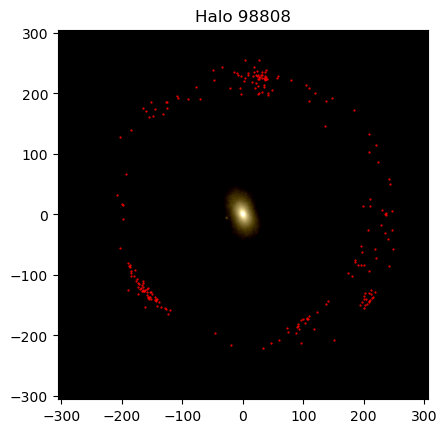

In [43]:
plt.imshow(rgb[::-1,:],extent=(-width / 2, width / 2, -width / 2, width / 2))
plt.title(f'Halo {haloid}')
#plt.scatter(peak_x1, peak_y1, color = 'red', s = 0.00002)
#plt.scatter(trough_x1, trough_y1, color = 'blue', s = 0.0007)
#plt.scatter(peak_x2, peak_y2, color = 'red', s = 0.0004)
#plt.scatter(trough_x2, trough_y2, color = 'blue', s = 0.01)
plt.scatter(peak_x3, peak_y3, color = 'red', s = 0.3)
#plt.scatter(trough_x3, trough_y3, color = 'blue', s = 0.2)
#plt.scatter(miss_x, miss_y, color = 'yellow', s = 0.01)
plt.show()

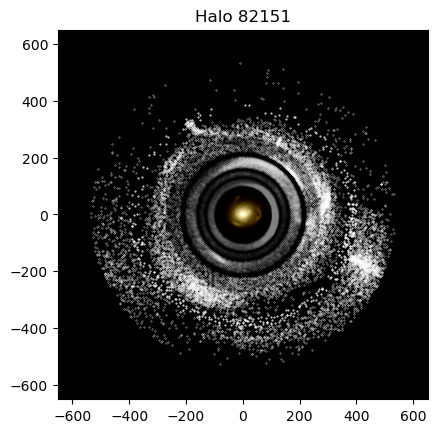

In [50]:
plt.imshow(rgb[::-1,:],extent=(-width / 2, width / 2, -width / 2, width / 2))
plt.title(f'Halo {haloid}')
plt.scatter(peak_x1, peak_y1, color = 'white', s = 0.00002)
plt.scatter(trough_x1, trough_y1, color = 'white', s = 0.00007)
plt.scatter(peak_x2, peak_y2, color = 'white', s = 0.0004)
plt.scatter(trough_x2, trough_y2, color = 'white', s = 0.01)
plt.scatter(peak_x3, peak_y3, color = 'white', s = 0.06)
plt.scatter(trough_x3, trough_y3, color = 'white', s = 0.2)
plt.scatter(miss_x, miss_y, color = 'white', s = 0.05)
plt.show()

In [51]:
outer_stars = bound[SolarNeighborhood(bins[-20], bins[-1], 2*Rvir)]
outer_pos = outer_stars['pos']
outer_x = outer_pos[:, 0]
outer_y = outer_pos[:, 1]

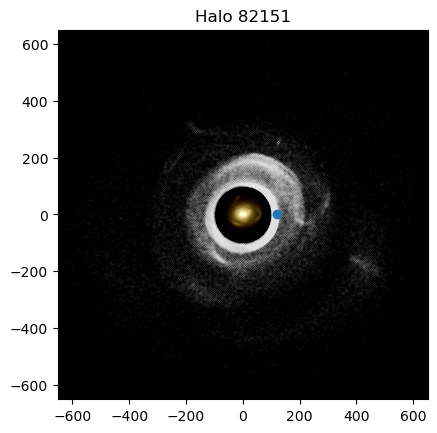

In [52]:
plt.imshow(rgb[::-1,:],extent=(-width / 2, width / 2, -width / 2, width / 2))
plt.title(f'Halo {haloid}')
plt.scatter(outer_x, outer_y, color = 'white', s = 0.0004)
plt.scatter(120, 0)

In [53]:
bins[-20]

103.22845287579544

In [55]:
stars_idx = peak_stars1['iord']

In [4]:
s1 = load_snapshot0('Romulus25', -2)

In [5]:
h1 = s1.halos(ahf_mpi = True) #load halo catalogue
len(h1) # There are a LOT of halos at z=0. You'll need to decide what kind of sample you want. (e.g., mass, host halo, etc)

103820

In [6]:
#haloid = halolist[12]
haloid = 82151
h0_old = h1[haloid]
h0_old

<SimSnap "/project/rrg-babul-ad/rennehan/romulus_data/cosmo25/cosmo25p.768sg1bwK1BHe75.007936:halo_82151" len=334>

In [7]:
old_stars = s1.stars

In [60]:
idx = np.where(np.in1d(old_stars['iord'], stars_idx, assume_unique=True))[0]
with open('Stars_idx.npy', 'wb') as f:
    np.save(f, idx)

In [8]:
idx = np.load('Stars_idx.npy')
old_stars = old_stars[idx]

In [62]:
R200 = MassRadii[1][200]
R500 = MassRadii[1][500]

In [44]:
width = 2*Rvir
rgb = pnb.plot.stars.render(bound[np.isnan(bound['r_lum_den'])==False], width = 2*Rvir, resolution = 1000, plot = False, ret_im = True)

Text(0.5, 1.0, 'Bound stars')

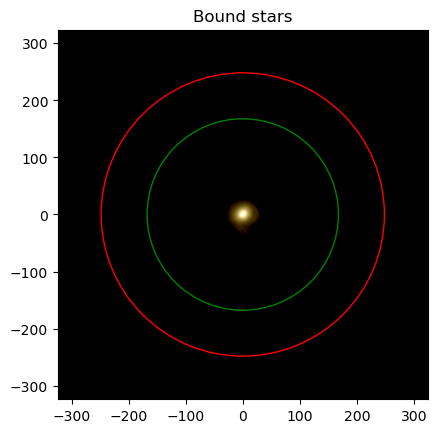

In [64]:
plt.imshow(rgb[::-1,:],extent=(-width / 2, width / 2, -width / 2, width / 2))
circle = plt.Circle((0, 0), R200, color = 'r', fill = False)
circle2 = plt.Circle((0, 0), R500, color = 'g', fill = False)
ax = plt.gca()
ax.add_patch(circle)
ax.add_patch(circle2)
plt.title(f"Bound stars")

In [46]:
width = 2*Rvir
rgb2 = pnb.plot.stars.render(unbound[np.isnan(unbound['r_lum_den'])==False], width = 2*Rvir, resolution = 1000, plot = False, ret_im = True)

Text(0.5, 1.0, 'Diffuse Stars')

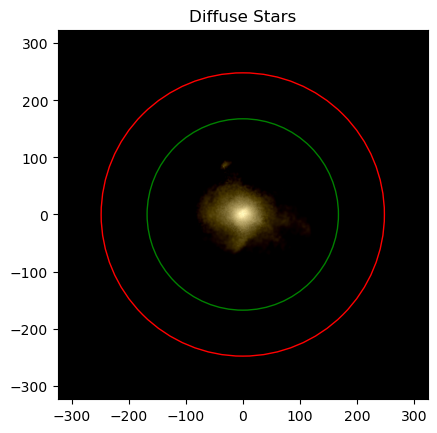

In [65]:
plt.imshow(rgb2[::-1,:],extent=(-width / 2, width / 2, -width / 2, width / 2))
circle = plt.Circle((0, 0), R200, color = 'r', fill = False)
circle2 = plt.Circle((0, 0), R500, color = 'g', fill = False)
ax = plt.gca()
ax.add_patch(circle)
ax.add_patch(circle2)
plt.title(f"Diffuse Stars")